# DOWSER V0 - Model Training for Water Depth Prediction

This notebook trains and evaluates models for predicting groundwater depth class.

**Task:** 3-class classification (water depth)
- Class 1: SURFACE (0-5m) - Springs
- Class 2: SHALLOW (5-20m) - Wells  
- Class 3: DEEP (30-100m) - Boreholes

**Input:** `waterpoints_with_features_corrected.parquet` (35,273 points × 11 features)

**Models:**
1. Random Forest (baseline)
2. XGBoost
3. MLP Neural Network

**Output:** Trained models + evaluation metrics

In [2]:
# ==============================================================
# CELL 1: Imports
# ==============================================================

import pandas as pd
import numpy as np
import geopandas as gpd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay
)

# XGBoost
try:
    import xgboost as xgb
    HAS_XGB = True
    print("✅ XGBoost available")
except ImportError:
    HAS_XGB = False
    print("⚠️ XGBoost not installed. Run: pip install xgboost")

# PyTorch for MLP
try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
    HAS_TORCH = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"✅ PyTorch available (device: {DEVICE})")
except ImportError:
    HAS_TORCH = False
    print("⚠️ PyTorch not installed. Run: pip install torch")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
PROJECT_ROOT = Path.cwd().parent
PROCESSED = PROJECT_ROOT / "data/processed"
MODELS_DIR = PROJECT_ROOT / "models"
FIGURES_DIR = PROJECT_ROOT / "outputs/figures"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"\nProject root: {PROJECT_ROOT}")
print(f"Data dir: {PROCESSED}")
print(f"Models dir: {MODELS_DIR}")

✅ XGBoost available
✅ PyTorch available (device: cpu)

Project root: /Users/leonardovannoli/work/dowser/dowser-v0
Data dir: /Users/leonardovannoli/work/dowser/dowser-v0/data/processed
Models dir: /Users/leonardovannoli/work/dowser/dowser-v0/models


In [3]:
# ==============================================================
# CELL 2: Load Data
# ==============================================================

# Load corrected dataset
data_path = PROCESSED / "waterpoints_with_features_corrected.parquet"

if not data_path.exists():
    # Fallback to original if corrected doesn't exist
    data_path = PROCESSED / "waterpoints_with_features.parquet"
    print(f"⚠️ Using original file: {data_path.name}")

df = gpd.read_parquet(data_path)
print(f"Loaded {len(df):,} samples")
print(f"Columns: {df.columns.tolist()}")

Loaded 35,273 samples
Columns: ['#lon_deg', '#lat_deg', 'country', '#clean_adm1', '#clean_adm2', 'class', 'source_type', 'success', '#status_clean', 'elevation', 'slope', 'aspect', 'ndvi', 'ndwi', 'precip_annual_mm', 'precip_seasonality', 'clay_pct', 'sand_pct', 'soc', 'water_occurrence', 'water_seasonality', 'landcover', 'geometry', 'class_original']


In [4]:
# ==============================================================
# CELL 3: Verify 3-Class Schema & Data Overview
# ==============================================================

print("="*60)
print("CLASS DISTRIBUTION")
print("="*60)

class_names = {
    1: "SURFACE (0-5m)",
    2: "SHALLOW (5-20m)", 
    3: "DEEP (30-100m)"
}

# Check for class 0
if 'class' in df.columns:
    class_col = 'class'
elif 'class_corrected' in df.columns:
    class_col = 'class_corrected'
else:
    raise ValueError("No class column found!")

class_dist = df[class_col].value_counts().sort_index()
print(f"\nUsing column: '{class_col}'")
print(f"\nClass distribution:")

for cls in class_dist.index:
    count = class_dist[cls]
    pct = count / len(df) * 100
    name = class_names.get(cls, f"UNKNOWN ({cls})")
    print(f"  {name}: {count:,} ({pct:.1f}%)")

# Validate
if 0 in class_dist.index:
    print("\n❌ ERROR: Class 0 found! Run data_correction_patch.py first.")
else:
    print("\n✅ Correct 3-class schema (no class 0)")

print(f"\nCountry distribution:")
print(df['country'].value_counts())

CLASS DISTRIBUTION

Using column: 'class'

Class distribution:
  SURFACE (0-5m): 5,171 (14.7%)
  SHALLOW (5-20m): 17,633 (50.0%)
  DEEP (30-100m): 12,469 (35.3%)

✅ Correct 3-class schema (no class 0)

Country distribution:
country
KEN    18315
TZA    16958
Name: count, dtype: int64


In [5]:
# ==============================================================
# CELL 4: Define Features and Target
# ==============================================================

# Feature columns (from GEE extraction)
FEATURE_COLS = [
    'elevation',
    'slope', 
    'aspect',
    'ndvi',
    'ndwi',
    'precip_annual_mm',
    'clay_pct',
    'sand_pct',
    'soc',
    'water_occurrence',
    'landcover'
]

# Check which features are available
available_features = [f for f in FEATURE_COLS if f in df.columns]
missing_features = [f for f in FEATURE_COLS if f not in df.columns]

print(f"Available features: {len(available_features)}/{len(FEATURE_COLS)}")
if missing_features:
    print(f"Missing features: {missing_features}")

# Use available features
FEATURES = available_features
TARGET = class_col

print(f"\nFeatures ({len(FEATURES)}): {FEATURES}")
print(f"Target: {TARGET}")

# Check for missing values
print(f"\nMissing values per feature:")
for feat in FEATURES:
    missing = df[feat].isna().sum()
    if missing > 0:
        print(f"  {feat}: {missing} ({missing/len(df)*100:.1f}%)")

Available features: 11/11

Features (11): ['elevation', 'slope', 'aspect', 'ndvi', 'ndwi', 'precip_annual_mm', 'clay_pct', 'sand_pct', 'soc', 'water_occurrence', 'landcover']
Target: class

Missing values per feature:


In [6]:
# ==============================================================
# CELL 5: Prepare Data
# ==============================================================

# Remove rows with missing features
df_clean = df.dropna(subset=FEATURES)
print(f"Samples after removing NaN: {len(df_clean):,} (removed {len(df)-len(df_clean):,})")

# Extract X and y
X = df_clean[FEATURES].values
y = df_clean[TARGET].values

# Convert labels to 0-indexed (1,2,3 -> 0,1,2) for PyTorch
y_zero_indexed = y - 1  # Now: 0=SURFACE, 1=SHALLOW, 2=DEEP

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"y unique values: {np.unique(y)}")
print(f"y_zero_indexed unique: {np.unique(y_zero_indexed)}")

Samples after removing NaN: 35,273 (removed 0)

X shape: (35273, 11)
y shape: (35273,)
y unique values: [1 2 3]
y_zero_indexed unique: [0 1 2]


In [7]:
# ==============================================================
# CELL 6: Train/Val/Test Split
# ==============================================================

# Split: 70% train, 15% val, 15% test
# Stratified to maintain class proportions

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_zero_indexed, 
    test_size=0.15, 
    random_state=42,
    stratify=y_zero_indexed
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.176,  # 0.176 of 0.85 ≈ 0.15 of total
    random_state=42,
    stratify=y_train_val
)

print(f"Train set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val set:   {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set:  {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Check class distribution in splits
print(f"\nClass distribution in train: {np.bincount(y_train)}")
print(f"Class distribution in val:   {np.bincount(y_val)}")
print(f"Class distribution in test:  {np.bincount(y_test)}")

Train set: 24,705 samples (70.0%)
Val set:   5,277 samples (15.0%)
Test set:  5,291 samples (15.0%)

Class distribution in train: [ 3621 12350  8734]
Class distribution in val:   [ 774 2638 1865]
Class distribution in test:  [ 776 2645 1870]


In [8]:
# ==============================================================
# CELL 7: Feature Scaling
# ==============================================================

scaler = StandardScaler()

# Fit on train only, transform all
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling applied (StandardScaler)")
print(f"\nTrain mean: {X_train_scaled.mean(axis=0).round(3)}")
print(f"Train std:  {X_train_scaled.std(axis=0).round(3)}")

Feature scaling applied (StandardScaler)

Train mean: [ 0.  0.  0.  0.  0. -0.  0.  0.  0. -0.  0.]
Train std:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


---
## Model 1: Random Forest (Baseline)
---

In [9]:
# ==============================================================
# CELL 8: Random Forest
# ==============================================================

print("Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf_train = rf_model.predict(X_train_scaled)
y_pred_rf_val = rf_model.predict(X_val_scaled)
y_pred_rf_test = rf_model.predict(X_test_scaled)

print("\n" + "="*60)
print("RANDOM FOREST RESULTS")
print("="*60)
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_rf_train):.4f}")
print(f"Val Accuracy:   {accuracy_score(y_val, y_pred_rf_val):.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_pred_rf_test):.4f}")

print(f"\nTest F1 (macro): {f1_score(y_test, y_pred_rf_test, average='macro'):.4f}")
print(f"Test F1 (weighted): {f1_score(y_test, y_pred_rf_test, average='weighted'):.4f}")

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s



RANDOM FOREST RESULTS
Train Accuracy: 0.9721
Val Accuracy:   0.7779
Test Accuracy:  0.7851

Test F1 (macro): 0.7806
Test F1 (weighted): 0.7847


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


Classification Report (Test Set):
                 precision    recall  f1-score   support

 SURFACE (0-5m)       0.77      0.82      0.79       776
SHALLOW (5-20m)       0.83      0.83      0.83      2645
 DEEP (30-100m)       0.73      0.71      0.72      1870

       accuracy                           0.79      5291
      macro avg       0.78      0.79      0.78      5291
   weighted avg       0.78      0.79      0.78      5291



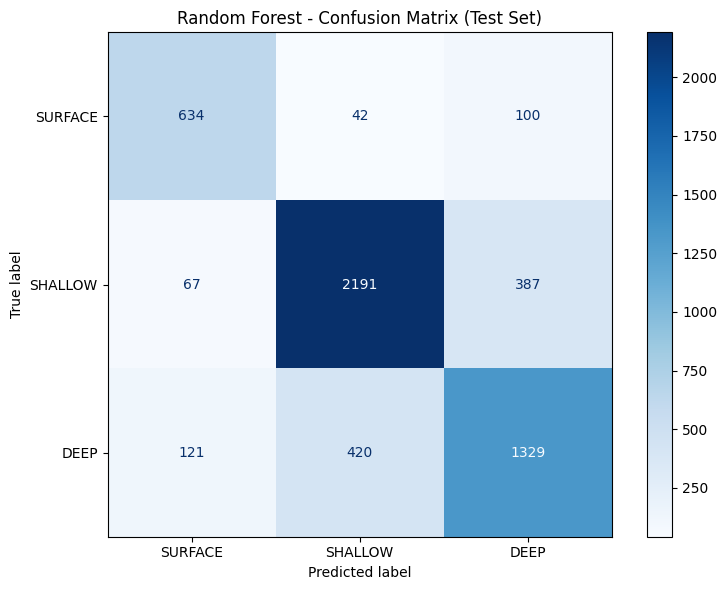

In [10]:
# ==============================================================
# CELL 9: Random Forest - Detailed Evaluation
# ==============================================================

print("Classification Report (Test Set):")
print(classification_report(
    y_test, y_pred_rf_test,
    target_names=['SURFACE (0-5m)', 'SHALLOW (5-20m)', 'DEEP (30-100m)']
))

# Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf_test)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['SURFACE', 'SHALLOW', 'DEEP']
)
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Random Forest - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'rf_confusion_matrix.png', dpi=150)
plt.show()

Feature Importance Ranking:
  1. precip_annual_mm: 0.1625
  2. sand_pct: 0.1549
  3. elevation: 0.1422
  4. slope: 0.1090
  5. clay_pct: 0.1017
  6. soc: 0.1016
  7. ndvi: 0.0877
  8. ndwi: 0.0693
  9. aspect: 0.0448
  10. landcover: 0.0258
  11. water_occurrence: 0.0004


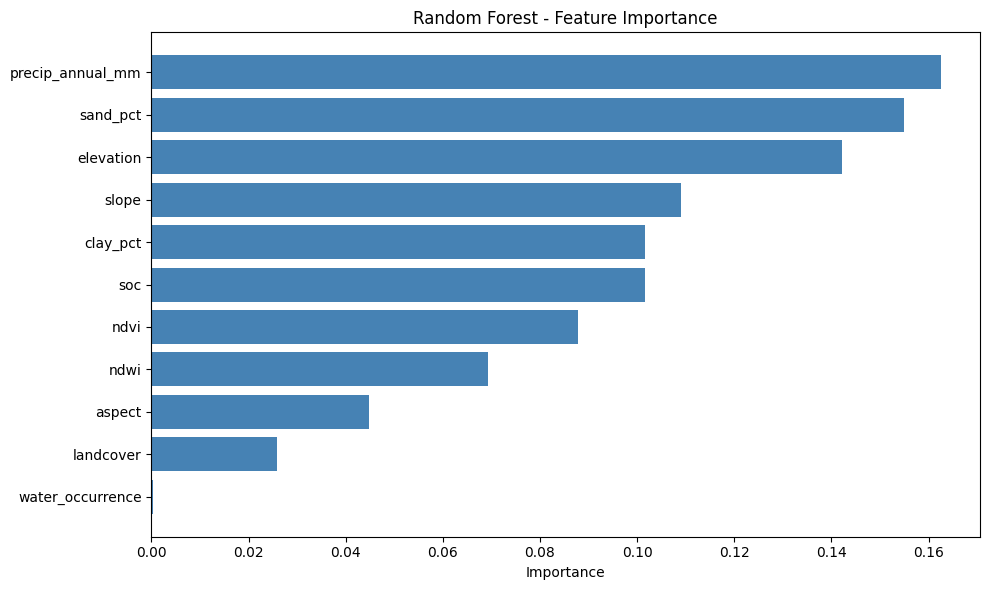

In [11]:
# ==============================================================
# CELL 10: Feature Importance (Random Forest)
# ==============================================================

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature Importance Ranking:")
for i, idx in enumerate(indices):
    print(f"  {i+1}. {FEATURES[idx]}: {importances[idx]:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(range(len(FEATURES)), importances[indices], color='steelblue')
ax.set_yticks(range(len(FEATURES)))
ax.set_yticklabels([FEATURES[i] for i in indices])
ax.invert_yaxis()
ax.set_xlabel('Importance')
ax.set_title('Random Forest - Feature Importance')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'rf_feature_importance.png', dpi=150)
plt.show()

---
## Model 2: XGBoost
---

In [12]:
# ==============================================================
# CELL 11: XGBoost
# ==============================================================

if not HAS_XGB:
    print("⚠️ XGBoost not available. Skipping...")
else:
    print("Training XGBoost...")
    
    # Calculate class weights
    class_counts = np.bincount(y_train)
    class_weights = len(y_train) / (len(class_counts) * class_counts)
    sample_weights = class_weights[y_train]
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softmax',
        num_class=3,
        random_state=42,
        n_jobs=-1,
        verbosity=1
    )
    
    xgb_model.fit(
        X_train_scaled, y_train,
        sample_weight=sample_weights,
        eval_set=[(X_val_scaled, y_val)],
        verbose=False
    )
    
    # Predictions
    y_pred_xgb_train = xgb_model.predict(X_train_scaled)
    y_pred_xgb_val = xgb_model.predict(X_val_scaled)
    y_pred_xgb_test = xgb_model.predict(X_test_scaled)
    
    print("\n" + "="*60)
    print("XGBOOST RESULTS")
    print("="*60)
    print(f"Train Accuracy: {accuracy_score(y_train, y_pred_xgb_train):.4f}")
    print(f"Val Accuracy:   {accuracy_score(y_val, y_pred_xgb_val):.4f}")
    print(f"Test Accuracy:  {accuracy_score(y_test, y_pred_xgb_test):.4f}")
    
    print(f"\nTest F1 (macro): {f1_score(y_test, y_pred_xgb_test, average='macro'):.4f}")
    print(f"Test F1 (weighted): {f1_score(y_test, y_pred_xgb_test, average='weighted'):.4f}")

Training XGBoost...

XGBOOST RESULTS
Train Accuracy: 0.9374
Val Accuracy:   0.7825
Test Accuracy:  0.7906

Test F1 (macro): 0.7882
Test F1 (weighted): 0.7907


Classification Report (Test Set):
                 precision    recall  f1-score   support

 SURFACE (0-5m)       0.75      0.86      0.81       776
SHALLOW (5-20m)       0.85      0.81      0.83      2645
 DEEP (30-100m)       0.73      0.73      0.73      1870

       accuracy                           0.79      5291
      macro avg       0.78      0.80      0.79      5291
   weighted avg       0.79      0.79      0.79      5291



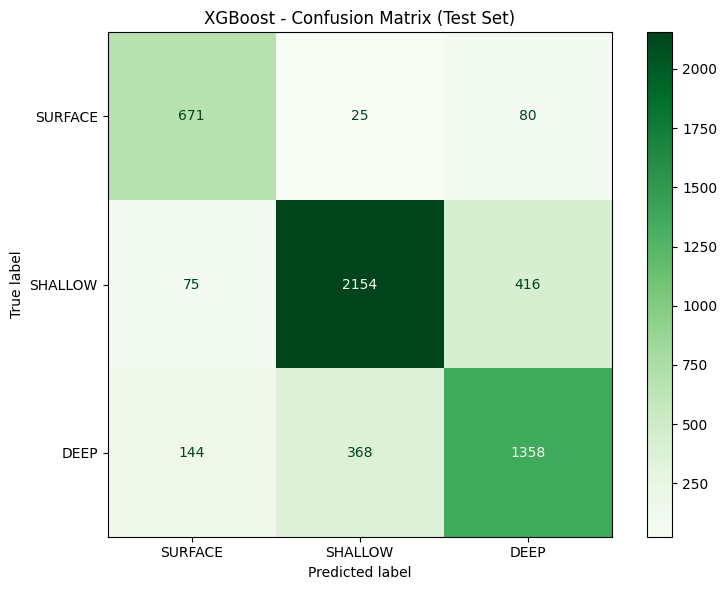

In [13]:
# ==============================================================
# CELL 12: XGBoost - Detailed Evaluation
# ==============================================================

if HAS_XGB:
    print("Classification Report (Test Set):")
    print(classification_report(
        y_test, y_pred_xgb_test,
        target_names=['SURFACE (0-5m)', 'SHALLOW (5-20m)', 'DEEP (30-100m)']
    ))
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_xgb_test)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['SURFACE', 'SHALLOW', 'DEEP']
    )
    disp.plot(ax=ax, cmap='Greens', values_format='d')
    ax.set_title('XGBoost - Confusion Matrix (Test Set)')
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'xgb_confusion_matrix.png', dpi=150)
    plt.show()

---
## Model 3: MLP Neural Network (PyTorch)
---

In [14]:
# ==============================================================
# CELL 13: Define MLP Architecture
# ==============================================================

if HAS_TORCH:
    
    class WaterDepthMLP(nn.Module):
        """
        Multi-Layer Perceptron for water depth classification.
        
        Architecture:
        - Input: n_features
        - Hidden: 128 -> 64 -> 32 (with BatchNorm, ReLU, Dropout)
        - Output: 3 classes
        """
        
        def __init__(self, n_features, n_classes=3, dropout=0.3):
            super(WaterDepthMLP, self).__init__()
            
            self.network = nn.Sequential(
                # Layer 1
                nn.Linear(n_features, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(dropout),
                
                # Layer 2
                nn.Linear(128, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Dropout(dropout),
                
                # Layer 3
                nn.Linear(64, 32),
                nn.BatchNorm1d(32),
                nn.ReLU(),
                nn.Dropout(dropout),
                
                # Output
                nn.Linear(32, n_classes)
            )
        
        def forward(self, x):
            return self.network(x)
    
    # Create model
    n_features = X_train_scaled.shape[1]
    mlp_model = WaterDepthMLP(n_features=n_features, n_classes=3).to(DEVICE)
    
    print(mlp_model)
    print(f"\nTotal parameters: {sum(p.numel() for p in mlp_model.parameters()):,}")
else:
    print("⚠️ PyTorch not available. Skipping MLP...")

WaterDepthMLP(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=3, bias=True)
  )
)

Total parameters: 12,419


In [15]:
# ==============================================================
# CELL 14: Prepare PyTorch DataLoaders
# ==============================================================

if HAS_TORCH:
    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train_scaled).to(DEVICE)
    y_train_t = torch.LongTensor(y_train).to(DEVICE)
    
    X_val_t = torch.FloatTensor(X_val_scaled).to(DEVICE)
    y_val_t = torch.LongTensor(y_val).to(DEVICE)
    
    X_test_t = torch.FloatTensor(X_test_scaled).to(DEVICE)
    y_test_t = torch.LongTensor(y_test).to(DEVICE)
    
    # Create datasets
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    
    # DataLoaders
    BATCH_SIZE = 256
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")

Train batches: 97
Val batches: 21
Test batches: 21


In [16]:
# ==============================================================
# CELL 14: Prepare PyTorch DataLoaders (SIMPLIFIED)
# ==============================================================

if HAS_TORCH:
    # Convert to tensors (stay on CPU)
    X_train_t = torch.FloatTensor(X_train_scaled)
    y_train_t = torch.LongTensor(y_train)
    
    X_val_t = torch.FloatTensor(X_val_scaled)
    y_val_t = torch.LongTensor(y_val)
    
    X_test_t = torch.FloatTensor(X_test_scaled)
    y_test_t = torch.LongTensor(y_test)
    
    print(f"✅ Tensors created")
    print(f"X_train_t device: {X_train_t.device}")
    print(f"   X_train: {X_train_t.shape}")
    print(f"   y_train: {y_train_t.shape}")
    
    # Create datasets
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    
    # DataLoaders
    BATCH_SIZE = 512  # Larger batch = faster
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"✅ DataLoaders ready")
    print(f"   Train batches: {len(train_loader)}")

✅ Tensors created
X_train_t device: cpu
   X_train: torch.Size([24705, 11])
   y_train: torch.Size([24705])
✅ DataLoaders ready
   Train batches: 49


In [17]:
# ==============================================================
# CELL 15: Training Loop
# ==============================================================

if HAS_TORCH:
    
    # Class weights for imbalanced data
    class_counts = np.bincount(y_train)
    class_weights = torch.FloatTensor(
        len(y_train) / (len(class_counts) * class_counts)
    ).to(DEVICE)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(mlp_model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    # Training settings
    N_EPOCHS = 100
    PATIENCE = 15
    
    # History
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print("Training MLP...")
    print("="*60)
    
    for epoch in range(N_EPOCHS):
        # Training
        mlp_model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = mlp_model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_total += y_batch.size(0)
            train_correct += (predicted == y_batch).sum().item()
        
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        
        # Validation
        mlp_model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = mlp_model(X_batch)
                loss = criterion(outputs, y_batch)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += y_batch.size(0)
                val_correct += (predicted == y_batch).sum().item()
        
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = mlp_model.state_dict().copy()
            patience_counter = 0
            marker = "*"
        else:
            patience_counter += 1
            marker = ""
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{N_EPOCHS} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} {marker}")
        
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Load best model
    mlp_model.load_state_dict(best_model_state)
    print(f"\n✅ Best model loaded (val_loss: {best_val_loss:.4f})")

Training MLP...
Epoch   1/100 | Train Loss: 0.9927 | Train Acc: 0.4792 | Val Loss: 0.9151 | Val Acc: 0.5372 *
Epoch  10/100 | Train Loss: 0.8221 | Train Acc: 0.5864 | Val Loss: 0.7807 | Val Acc: 0.6246 *
Epoch  20/100 | Train Loss: 0.7687 | Train Acc: 0.6132 | Val Loss: 0.7250 | Val Acc: 0.6511 *
Epoch  30/100 | Train Loss: 0.7376 | Train Acc: 0.6395 | Val Loss: 0.6972 | Val Acc: 0.6684 *
Epoch  40/100 | Train Loss: 0.7228 | Train Acc: 0.6471 | Val Loss: 0.6797 | Val Acc: 0.6741 *
Epoch  50/100 | Train Loss: 0.7113 | Train Acc: 0.6528 | Val Loss: 0.6705 | Val Acc: 0.6847 
Epoch  60/100 | Train Loss: 0.7020 | Train Acc: 0.6608 | Val Loss: 0.6566 | Val Acc: 0.6847 *
Epoch  70/100 | Train Loss: 0.6930 | Train Acc: 0.6694 | Val Loss: 0.6535 | Val Acc: 0.6885 
Epoch  80/100 | Train Loss: 0.6822 | Train Acc: 0.6718 | Val Loss: 0.6499 | Val Acc: 0.6864 
Epoch  90/100 | Train Loss: 0.6857 | Train Acc: 0.6726 | Val Loss: 0.6428 | Val Acc: 0.6941 *
Epoch 100/100 | Train Loss: 0.6832 | Train Acc:

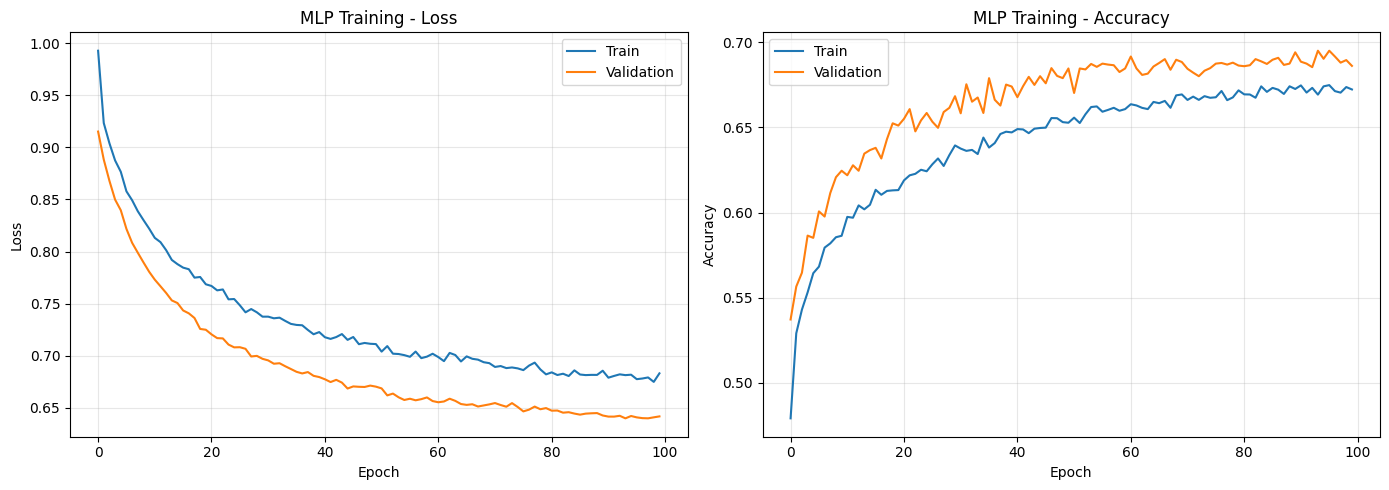

In [18]:
# ==============================================================
# CELL 16: Plot Training History
# ==============================================================

if HAS_TORCH:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train')
    axes[0].plot(history['val_loss'], label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('MLP Training - Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(history['train_acc'], label='Train')
    axes[1].plot(history['val_acc'], label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('MLP Training - Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'mlp_training_history.png', dpi=150)
    plt.show()

MLP RESULTS
Test Accuracy:  0.6936
Test F1 (macro): 0.6838
Test F1 (weighted): 0.6970

Classification Report (Test Set):
                 precision    recall  f1-score   support

 SURFACE (0-5m)       0.56      0.86      0.67       776
SHALLOW (5-20m)       0.83      0.70      0.76      2645
 DEEP (30-100m)       0.62      0.62      0.62      1870

       accuracy                           0.69      5291
      macro avg       0.67      0.72      0.68      5291
   weighted avg       0.72      0.69      0.70      5291



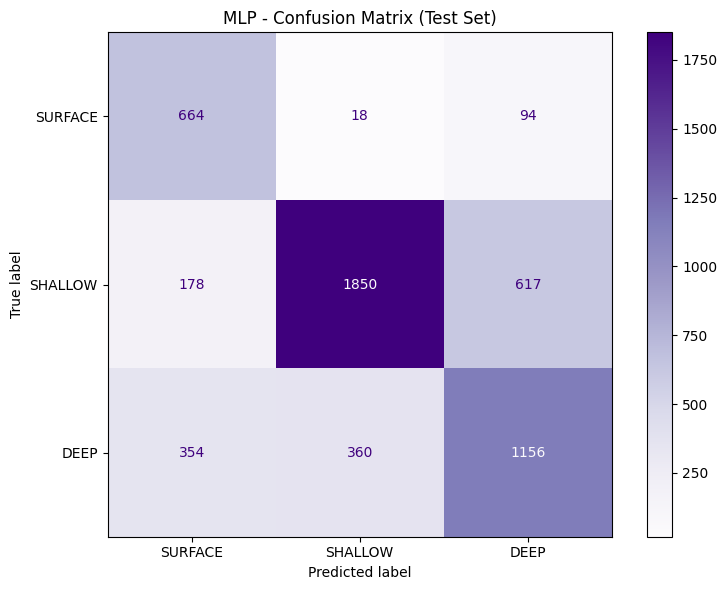

In [19]:
# ==============================================================
# CELL 17: MLP Evaluation
# ==============================================================

if HAS_TORCH:
    mlp_model.eval()
    
    with torch.no_grad():
        # Test predictions
        outputs = mlp_model(X_test_t)
        _, y_pred_mlp = torch.max(outputs, 1)
        y_pred_mlp = y_pred_mlp.cpu().numpy()
    
    print("="*60)
    print("MLP RESULTS")
    print("="*60)
    print(f"Test Accuracy:  {accuracy_score(y_test, y_pred_mlp):.4f}")
    print(f"Test F1 (macro): {f1_score(y_test, y_pred_mlp, average='macro'):.4f}")
    print(f"Test F1 (weighted): {f1_score(y_test, y_pred_mlp, average='weighted'):.4f}")
    
    print("\nClassification Report (Test Set):")
    print(classification_report(
        y_test, y_pred_mlp,
        target_names=['SURFACE (0-5m)', 'SHALLOW (5-20m)', 'DEEP (30-100m)']
    ))
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_mlp)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['SURFACE', 'SHALLOW', 'DEEP']
    )
    disp.plot(ax=ax, cmap='Purples', values_format='d')
    ax.set_title('MLP - Confusion Matrix (Test Set)')
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'mlp_confusion_matrix.png', dpi=150)
    plt.show()

---
## Model Comparison
---

MODEL COMPARISON (Test Set)
        Model  Accuracy  F1 (macro)  F1 (weighted)
Random Forest  0.785107    0.780568       0.784712
      XGBoost  0.790588    0.788195       0.790697
          MLP  0.693631    0.683797       0.696999


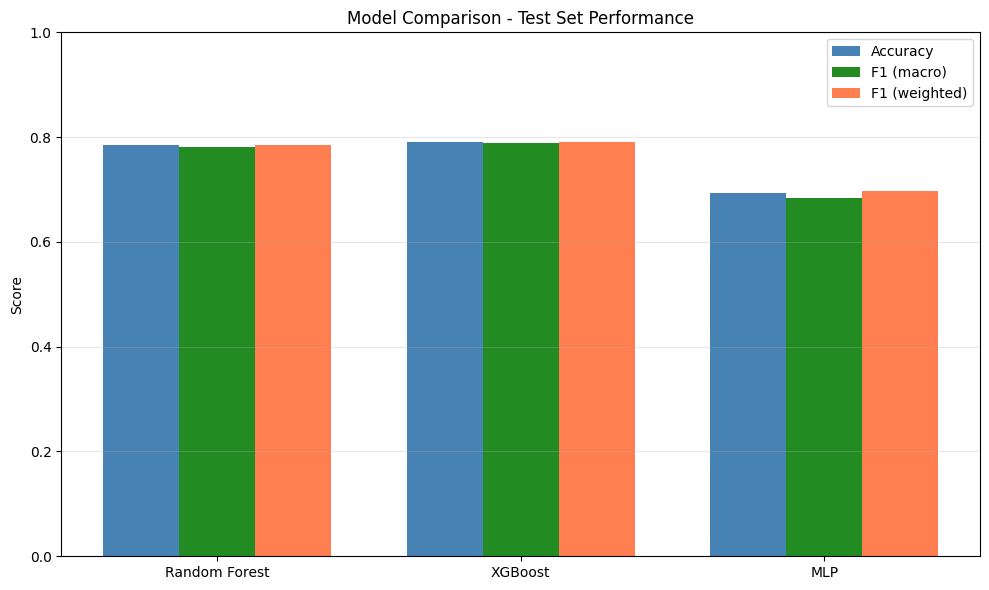

In [20]:
# ==============================================================
# CELL 18: Compare All Models
# ==============================================================

print("="*60)
print("MODEL COMPARISON (Test Set)")
print("="*60)

results = []

# Random Forest
results.append({
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf_test),
    'F1 (macro)': f1_score(y_test, y_pred_rf_test, average='macro'),
    'F1 (weighted)': f1_score(y_test, y_pred_rf_test, average='weighted')
})

# XGBoost
if HAS_XGB:
    results.append({
        'Model': 'XGBoost',
        'Accuracy': accuracy_score(y_test, y_pred_xgb_test),
        'F1 (macro)': f1_score(y_test, y_pred_xgb_test, average='macro'),
        'F1 (weighted)': f1_score(y_test, y_pred_xgb_test, average='weighted')
    })

# MLP
if HAS_TORCH:
    results.append({
        'Model': 'MLP',
        'Accuracy': accuracy_score(y_test, y_pred_mlp),
        'F1 (macro)': f1_score(y_test, y_pred_mlp, average='macro'),
        'F1 (weighted)': f1_score(y_test, y_pred_mlp, average='weighted')
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.25

ax.bar(x - width, results_df['Accuracy'], width, label='Accuracy', color='steelblue')
ax.bar(x, results_df['F1 (macro)'], width, label='F1 (macro)', color='forestgreen')
ax.bar(x + width, results_df['F1 (weighted)'], width, label='F1 (weighted)', color='coral')

ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'])
ax.set_ylabel('Score')
ax.set_title('Model Comparison - Test Set Performance')
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'model_comparison.png', dpi=150)
plt.show()

In [21]:
# ==============================================================
# CELL 19: Save Models
# ==============================================================

import joblib

# Save Random Forest
joblib.dump(rf_model, MODELS_DIR / 'random_forest.joblib')
print(f"✅ Saved: {MODELS_DIR / 'random_forest.joblib'}")

# Save XGBoost
if HAS_XGB:
    joblib.dump(xgb_model, MODELS_DIR / 'xgboost.joblib')
    print(f"✅ Saved: {MODELS_DIR / 'xgboost.joblib'}")

# Save MLP
if HAS_TORCH:
    torch.save({
        'model_state_dict': mlp_model.state_dict(),
        'n_features': n_features,
        'n_classes': 3,
        'feature_names': FEATURES,
        'class_names': class_names
    }, MODELS_DIR / 'mlp_model.pt')
    print(f"✅ Saved: {MODELS_DIR / 'mlp_model.pt'}")

# Save scaler
joblib.dump(scaler, MODELS_DIR / 'scaler.joblib')
print(f"✅ Saved: {MODELS_DIR / 'scaler.joblib'}")

# Save results
results_df.to_csv(MODELS_DIR / 'model_comparison_results.csv', index=False)
print(f"✅ Saved: {MODELS_DIR / 'model_comparison_results.csv'}")

✅ Saved: /Users/leonardovannoli/work/dowser/dowser-v0/models/random_forest.joblib
✅ Saved: /Users/leonardovannoli/work/dowser/dowser-v0/models/xgboost.joblib
✅ Saved: /Users/leonardovannoli/work/dowser/dowser-v0/models/mlp_model.pt
✅ Saved: /Users/leonardovannoli/work/dowser/dowser-v0/models/scaler.joblib
✅ Saved: /Users/leonardovannoli/work/dowser/dowser-v0/models/model_comparison_results.csv


In [22]:
# ==============================================================
# CELL 20: Final Summary
# ==============================================================

print("="*60)
print("TRAINING COMPLETE")
print("="*60)

print(f"\n📊 Dataset:")
print(f"   Total samples: {len(df_clean):,}")
print(f"   Features: {len(FEATURES)}")
print(f"   Classes: 3 (SURFACE, SHALLOW, DEEP)")

print(f"\n🏆 Best Model: {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']}")
print(f"   Accuracy: {results_df['Accuracy'].max():.4f}")
print(f"   F1 (macro): {results_df['F1 (macro)'].max():.4f}")

print(f"\n📁 Saved files:")
print(f"   Models: {MODELS_DIR}")
print(f"   Figures: {FIGURES_DIR}")

print(f"\n✅ Ready for inference!")

TRAINING COMPLETE

📊 Dataset:
   Total samples: 35,273
   Features: 11
   Classes: 3 (SURFACE, SHALLOW, DEEP)

🏆 Best Model: XGBoost
   Accuracy: 0.7906
   F1 (macro): 0.7882

📁 Saved files:
   Models: /Users/leonardovannoli/work/dowser/dowser-v0/models
   Figures: /Users/leonardovannoli/work/dowser/dowser-v0/outputs/figures

✅ Ready for inference!
